In [80]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

In [81]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder: Input -> Hidden layers
        self.fc1 = nn.Linear(28*28, 512)  # Flattened input
        self.fc21 = nn.Linear(512, latent_dim)    # Mean of the latent space
        self.fc22 = nn.Linear(512, latent_dim)    # Log-variance of the latent space

        # Decoder: Latent space -> Output
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 28*28)  # Output size

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)  # Mean and log-variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)    # Sample epsilon
        return mu + eps * std          # Reparameterization trick

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))  # Flatten input
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    # KL Divergence term
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

latent_dim = 20
epochs = 50
batch_size=128
lr=1e-3

In [82]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1, Loss: 283.0912
Epoch 2, Loss: 255.3281
Epoch 3, Loss: 249.6733
Epoch 4, Loss: 246.8589
Epoch 5, Loss: 245.3078
Epoch 6, Loss: 244.3139
Epoch 7, Loss: 243.5810
Epoch 8, Loss: 243.0173
Epoch 9, Loss: 242.5093
Epoch 10, Loss: 242.1149
Epoch 11, Loss: 241.7377
Epoch 12, Loss: 241.3956
Epoch 13, Loss: 241.1658
Epoch 14, Loss: 240.8998
Epoch 15, Loss: 240.7101
Epoch 16, Loss: 240.4998
Epoch 17, Loss: 240.2738
Epoch 18, Loss: 240.1417
Epoch 19, Loss: 240.0261
Epoch 20, Loss: 239.8841
Epoch 21, Loss: 239.7132
Epoch 22, Loss: 239.6127
Epoch 23, Loss: 239.4975
Epoch 24, Loss: 239.3736
Epoch 25, Loss: 239.2982
Epoch 26, Loss: 239.1587
Epoch 27, Loss: 239.1203
Epoch 28, Loss: 239.0127
Epoch 29, Loss: 238.9668
Epoch 30, Loss: 238.8477
Epoch 31, Loss: 238.8310
Epoch 32, Loss: 238.7454
Epoch 33, Loss: 238.6753
Epoch 34, Loss: 238.6415
Epoch 35, Loss: 238.5892
Epoch 36, Loss: 238.4926
Epoch 37, Loss: 238.4324
Epoch 38, Loss: 238.3655
Epoch 39, Loss: 238.3623
Epoch 40, Loss: 238.3226
Epoch 41,

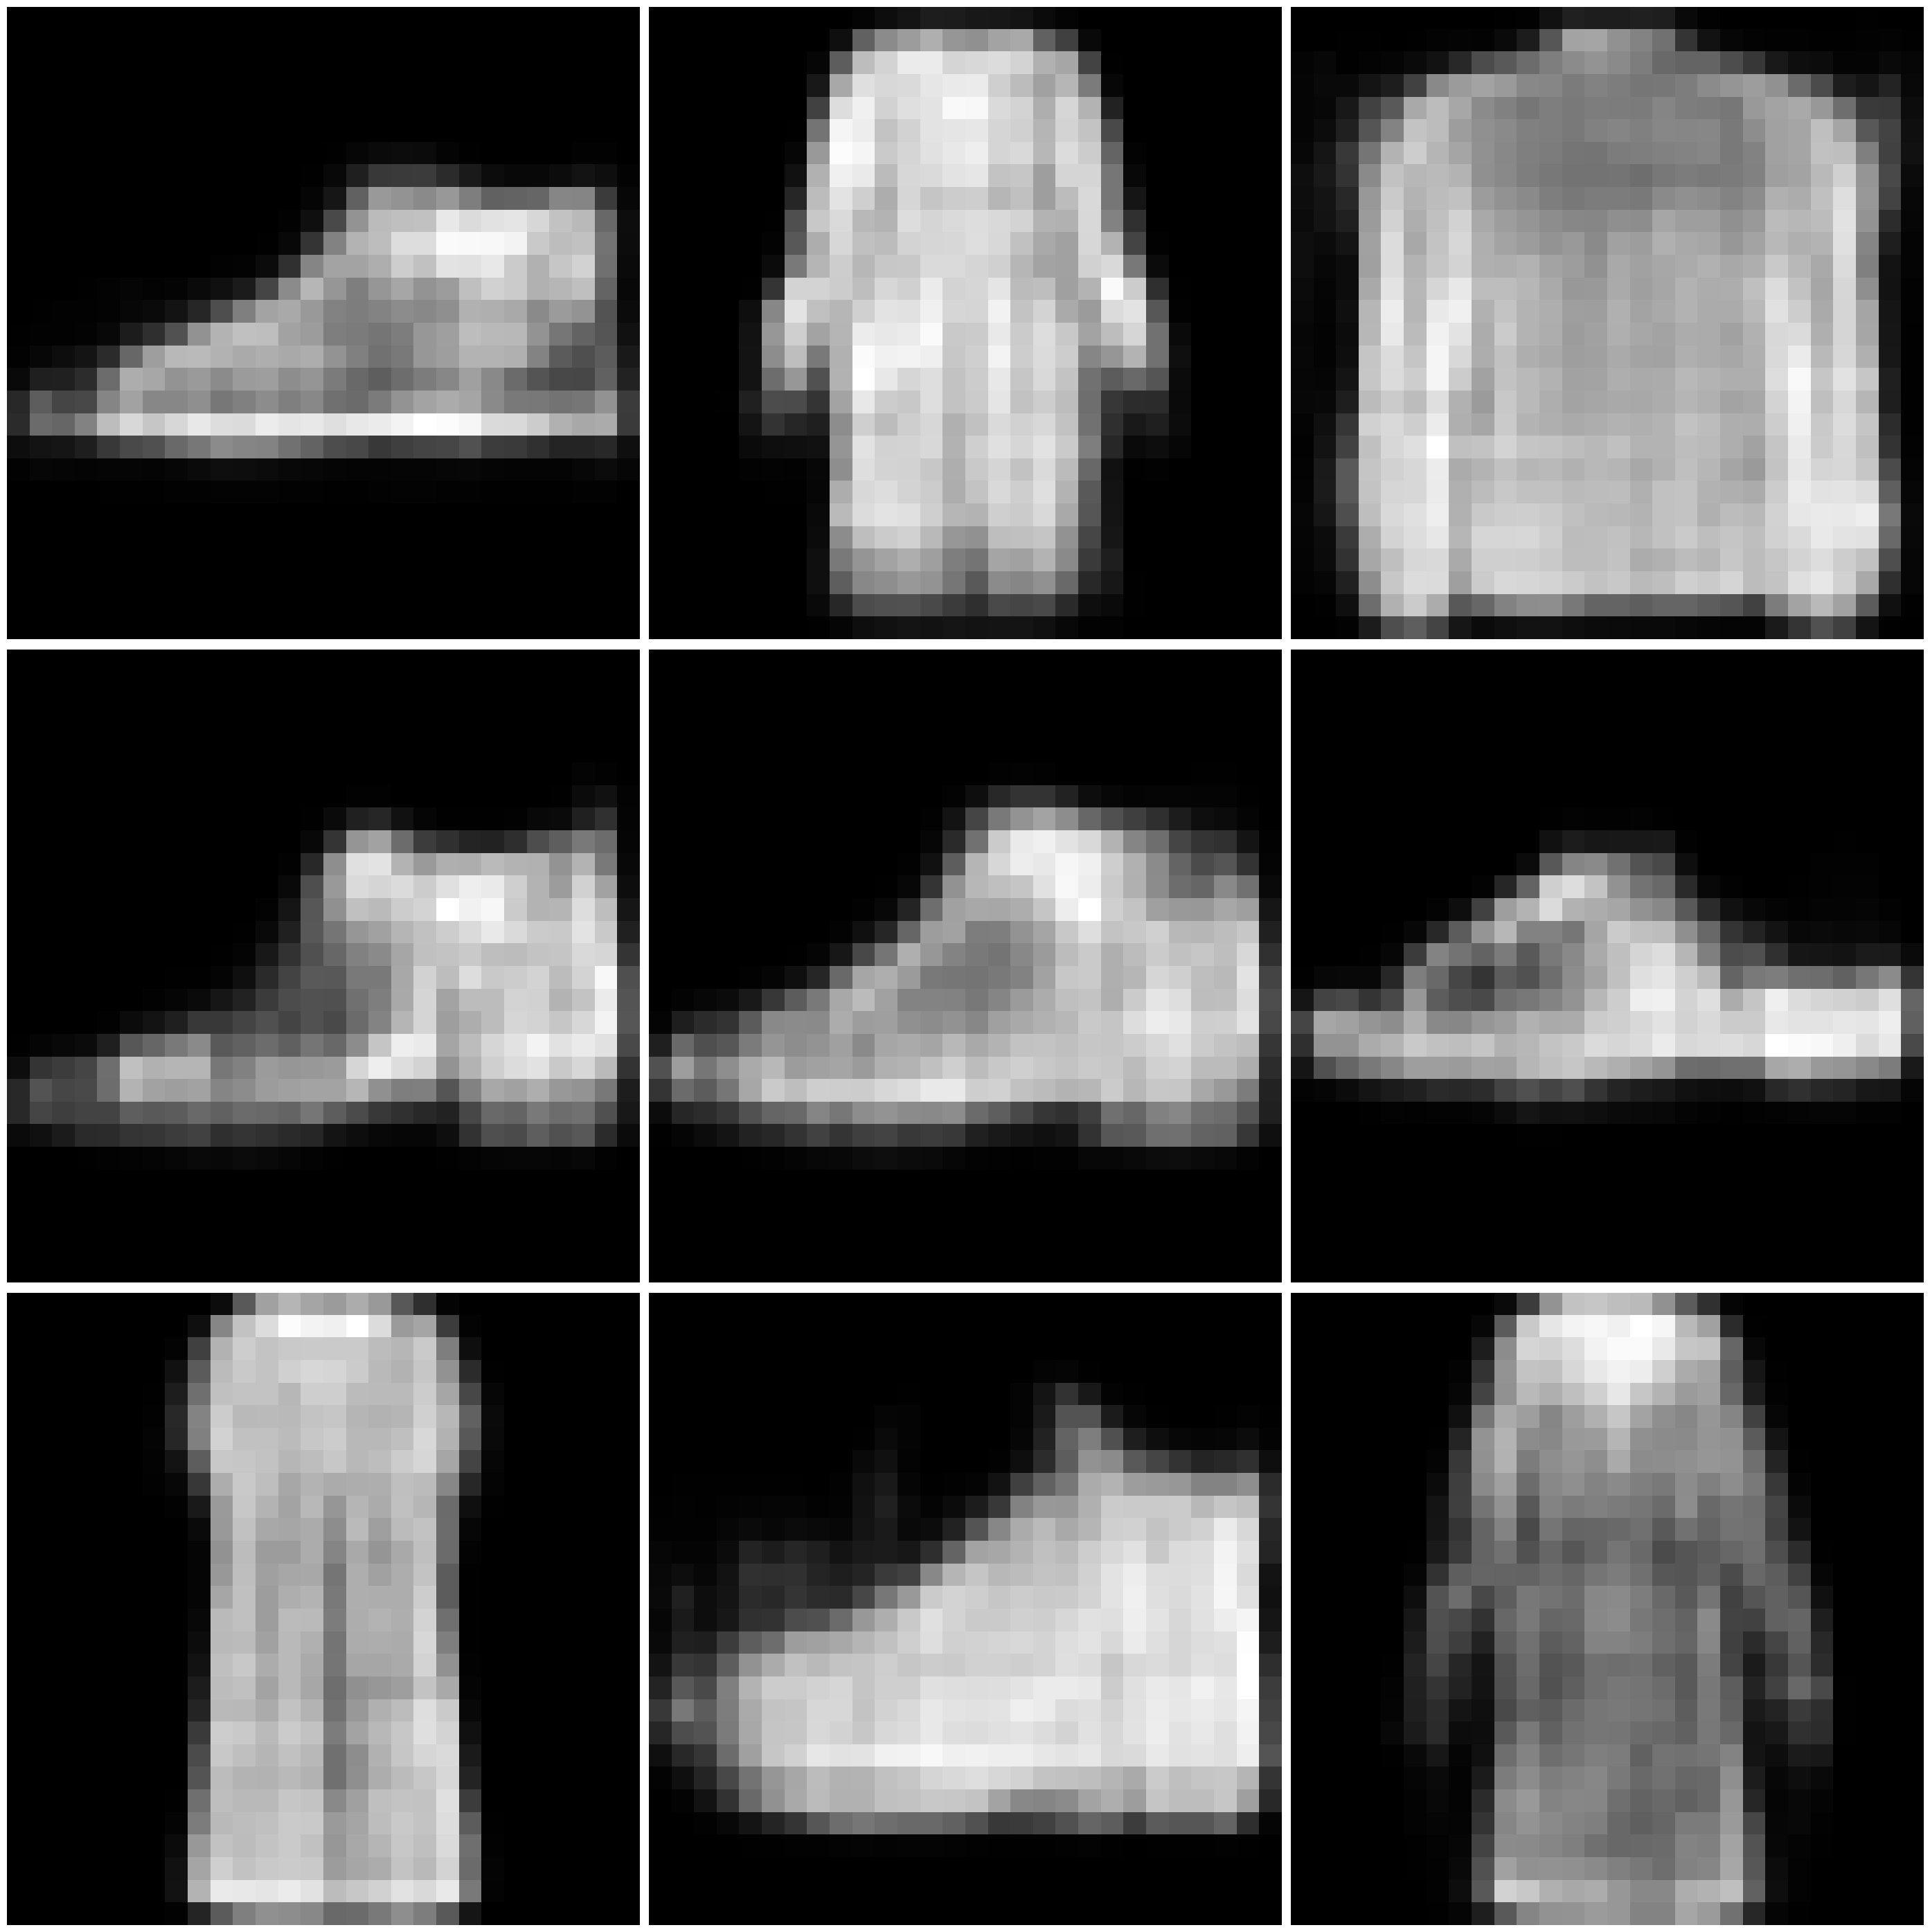

In [87]:
import matplotlib.pyplot as plt
import torchvision
import torch

model.eval()
with torch.no_grad():
    z = torch.randn(9, latent_dim).to(device)
    sample = model.decode(z).cpu()

    fig, axes = plt.subplots(3, 3, figsize=(28, 28))
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            idx = i * 3 + j
            ax.imshow(sample[idx].view(28, 28), cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()
